In [ ]:
pip install ucimlrepo


In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
individual_household_electric_power_consumption = fetch_ucirepo(id=235)

# data (as pandas dataframes)
X = individual_household_electric_power_consumption.data.features
y = individual_household_electric_power_consumption.data.targets

# metadata
print(individual_household_electric_power_consumption.metadata)

# variable information
print(individual_household_electric_power_consumption.variables)

{'uci_id': 235, 'name': 'Individual Household Electric Power Consumption', 'repository_url': 'https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption', 'data_url': 'https://archive.ics.uci.edu/static/public/235/data.csv', 'abstract': 'Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.', 'area': 'Physics and Chemistry', 'tasks': ['Regression', 'Clustering'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 2075259, 'num_features': 9, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2006, 'last_updated': 'Fri Mar 08 2024', 'dataset_doi': '10.24432/C58K54', 'creators': ['Georges Hebrail', 'Alice Berard'], 'intro_paper': None, 'additional_info': {'summary': 'This archiv

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step


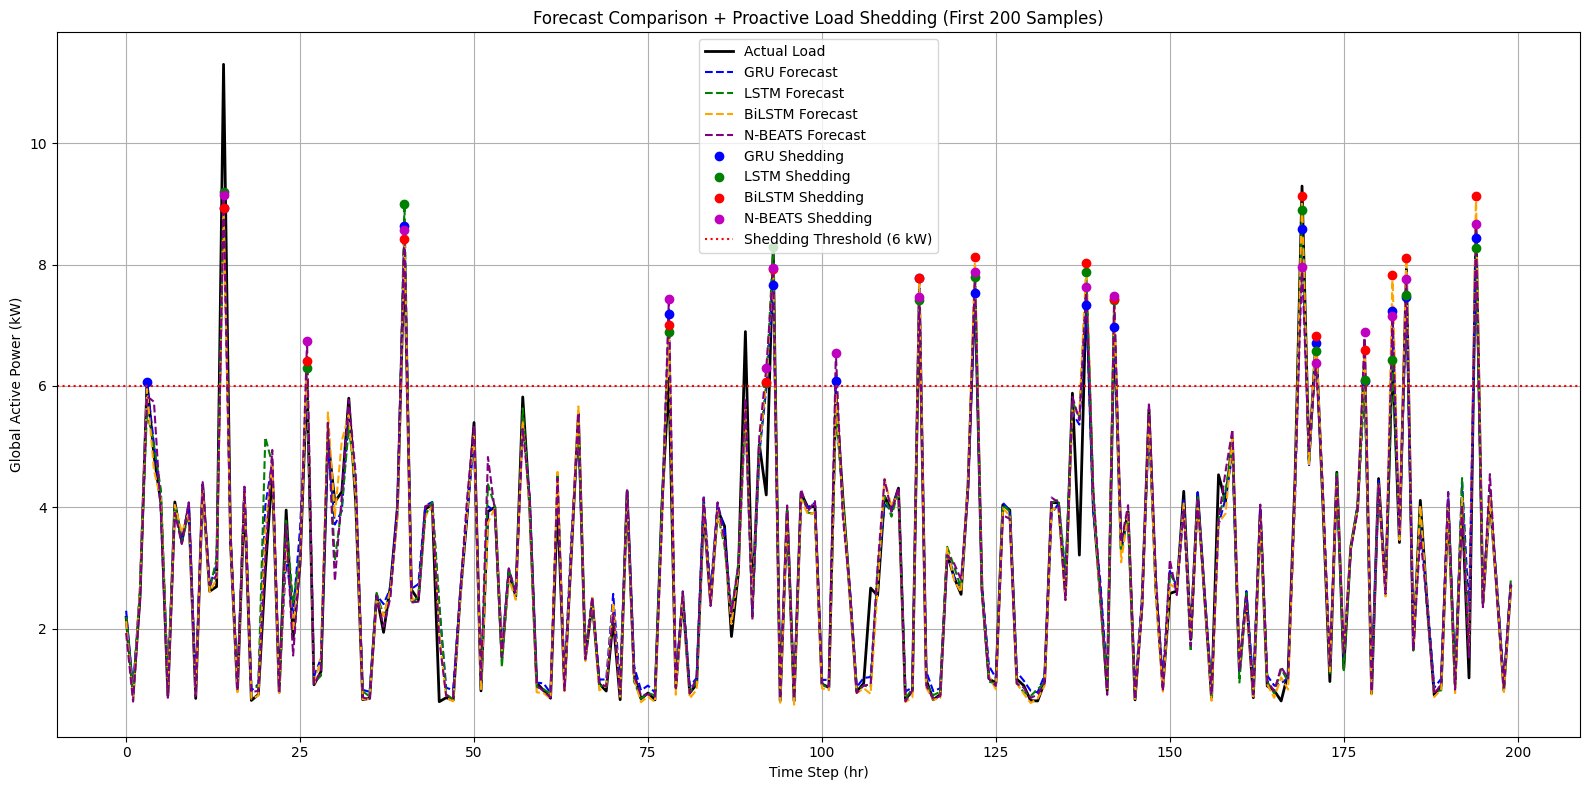

In [ ]:
# 📌 Full Unified Code for GRU, LSTM, BiLSTM, N-BEATS with Forecasting + Shedding Plot

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Dropout
from ucimlrepo import fetch_ucirepo
import warnings
warnings.filterwarnings('ignore')

# Fetch dataset
data = fetch_ucirepo(id=235)
X = data.data.features
y = data.data.targets
df = pd.concat([X, y], axis=1)

# Datetime processing
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df.set_index('datetime', inplace=True)
df.drop(columns=['Date', 'Time'], inplace=True)

# Numeric conversion and fill missing
df = df.apply(pd.to_numeric, errors='coerce')
df.fillna(df.mean(), inplace=True)

# Feature engineering
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['weekday'] = df.index.weekday

# Reduce dataset
df = df.iloc[:50000]

# Normalize
df_scaled = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns, index=df.index)

# Prepare features and target
X_data = df_scaled.drop(columns=['Global_active_power'])
y_data = df_scaled['Global_active_power']

# Create sequences
def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32)

X_seq, y_seq = create_sequences(X_data.values, y_data.values, time_steps=12)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Define model builder
def build_and_train(model_type='GRU'):
    model = Sequential()
    if model_type == 'GRU':
        model.add(GRU(32, return_sequences=True, input_shape=(12, X_train.shape[2])))
        model.add(Dropout(0.2))
        model.add(GRU(16))
    elif model_type == 'LSTM':
        model.add(LSTM(32, return_sequences=True, input_shape=(12, X_train.shape[2])))
        model.add(Dropout(0.2))
        model.add(LSTM(16))
    elif model_type == 'BiLSTM':
        model.add(Bidirectional(LSTM(32, return_sequences=True), input_shape=(12, X_train.shape[2])))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(16)))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0)
    return model

# Train all models
gru_model = build_and_train('GRU')
lstm_model = build_and_train('LSTM')
bilstm_model = build_and_train('BiLSTM')

# Simple N-BEATS like dense model (not real N-BEATS block)
def build_nbeats():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(12 * X_train.shape[2],)),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

X_train_nbeats = X_train.reshape((X_train.shape[0], -1))
X_test_nbeats = X_test.reshape((X_test.shape[0], -1))
nbeats_model = build_nbeats()
nbeats_model.fit(X_train_nbeats, y_train, epochs=10, batch_size=16, verbose=0)

# Inverse scaler setup
scaler = StandardScaler().fit(df)
full_cols = list(df.columns)
X_last = X_test[:, -1, :]

# Helper for prediction + inverse

def inverse_predictions(model, X, model_type='RNN'):
    if model_type == 'NBEATS':
        pred = model.predict(X.reshape((X.shape[0], -1)))
    else:
        pred = model.predict(X)
    pred_full = np.hstack([X[:, -1, :], pred])
    test_full = np.hstack([X[:, -1, :], y_test.reshape(-1, 1)])
    y_pred_actual = scaler.inverse_transform(pd.DataFrame(pred_full, columns=full_cols))[:, -1]
    y_test_actual = scaler.inverse_transform(pd.DataFrame(test_full, columns=full_cols))[:, -1]
    return y_pred_actual, y_test_actual

# Forecast and evaluate
pred_gru, y_actual = inverse_predictions(gru_model, X_test)
pred_lstm, _ = inverse_predictions(lstm_model, X_test)
pred_bilstm, _ = inverse_predictions(bilstm_model, X_test)
pred_nbeats, _ = inverse_predictions(nbeats_model, X_test, model_type='NBEATS')

# Shedding logic
threshold = 6
shed_gru = pred_gru > threshold
shed_lstm = pred_lstm > threshold
shed_bilstm = pred_bilstm > threshold
shed_nbeats = pred_nbeats > threshold

# Plot all in one
y_actual = y_actual[:200]
pred_gru = pred_gru[:200]
pred_lstm = pred_lstm[:200]
pred_bilstm = pred_bilstm[:200]
pred_nbeats = pred_nbeats[:200]
shed_gru = shed_gru[:200]
shed_lstm = shed_lstm[:200]
shed_bilstm = shed_bilstm[:200]
shed_nbeats = shed_nbeats[:200]

plt.figure(figsize=(16, 8))
plt.plot(y_actual, label='Actual Load', color='black', linewidth=2)
plt.plot(pred_gru, '--', label='GRU Forecast', color='blue')
plt.plot(pred_lstm, '--', label='LSTM Forecast', color='green')
plt.plot(pred_bilstm, '--', label='BiLSTM Forecast', color='orange')
plt.plot(pred_nbeats, '--', label='N-BEATS Forecast', color='purple')

plt.plot(np.where(shed_gru, pred_gru, np.nan), 'bo', label='GRU Shedding')
plt.plot(np.where(shed_lstm, pred_lstm, np.nan), 'go', label='LSTM Shedding')
plt.plot(np.where(shed_bilstm, pred_bilstm, np.nan), 'ro', label='BiLSTM Shedding')
plt.plot(np.where(shed_nbeats, pred_nbeats, np.nan), 'mo', label='N-BEATS Shedding')

plt.title('Forecast Comparison + Proactive Load Shedding (First 200 Samples)')
plt.axhline(y=threshold, linestyle='dotted', color='red', label='Shedding Threshold (6 kW)')
plt.xlabel('Time Step (hr)')
plt.ylabel('Global Active Power (kW)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
